In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy
from rdkit import Chem

In [18]:
from torch_geometric.nn.models import GIN

ImportError: cannot import name 'GIN' from 'torch_geometric.nn.models' (C:\Users\alexa\.conda\envs\hoai\lib\site-packages\torch_geometric\nn\models\__init__.py)

In [2]:
data_molecules = Chem.SDMolSupplier(r'tox21_10k_data_all.sdf')
print(len(data_molecules))

11764


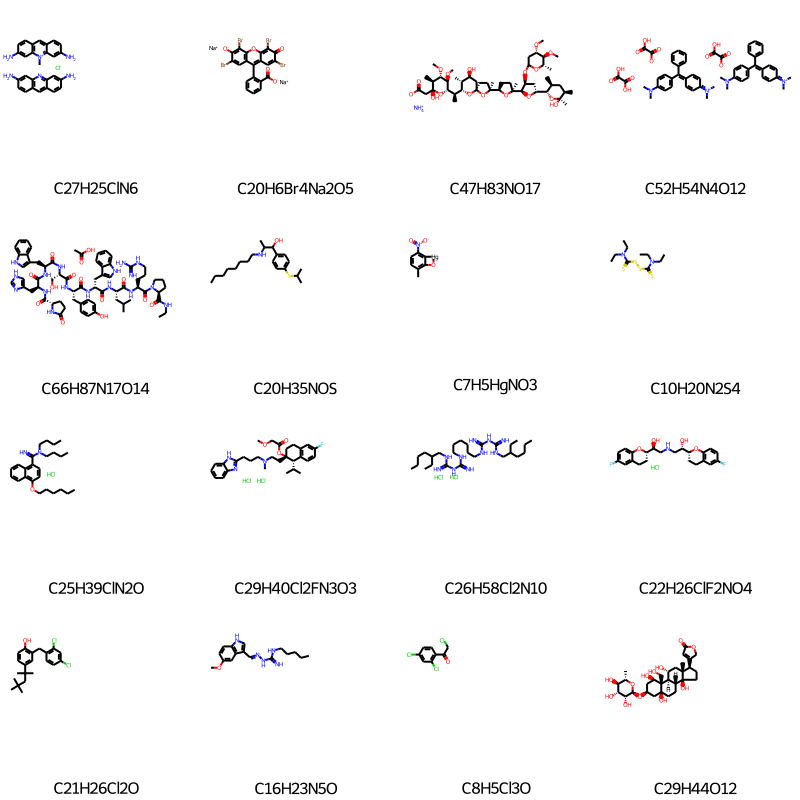

In [15]:
lumolist = [(i, smol.GetProp(r"Formula"), smol) for (i, smol) in enumerate(data_molecules) if smol is not None]
specific_molecules = [t[2] for t in lumolist[:16]]
specific_molecule_labels = [t[1] for t in lumolist[:16]]

Chem.Draw.MolsToGridImage(
    specific_molecules,
    legends=specific_molecule_labels,
    maxMols=len(specific_molecules),
    molsPerRow=4)

# TODOs

- Eventually make benchmarks work: https://github.com/weihua916/powerful-gnns
    - Make These Benchmarks work with the tix21 dataset

# Experiments

In [15]:
data = load_data(dataset = "powerful-gnns-master/dataset/PROTEINS/PROTEINS.txt", degree_as_tag = True)

loading data
['42', '0'] 42 0
# classes: 2
# maximum node tag: 17
# data: 1113


In [14]:
import networkx as nx
import numpy as np
import random
import torch
from sklearn.model_selection import StratifiedKFold

class S2VGraph(object):
    def __init__(self, g, label, node_tags=None, node_features=None):
        '''
            g: a networkx graph
            label: an integer graph label
            node_tags: a list of integer node tags
            node_features: a torch float tensor, one-hot representation of the tag that is used as input to neural nets
            edge_mat: a torch long tensor, contain edge list, will be used to create torch sparse tensor
            neighbors: list of neighbors (without self-loop)
        '''
        self.label = label
        self.g = g
        self.node_tags = node_tags
        self.neighbors = []
        self.node_features = 0
        self.edge_mat = 0

        self.max_neighbor = 0

def load_data(dataset, degree_as_tag):
    '''
        dataset: name of dataset
        test_proportion: ratio of test train split
        seed: random seed for random splitting of dataset
    '''

    print('loading data')
    g_list = []
    label_dict = {}
    feat_dict = {}

    with open(dataset, 'r') as f:
        n_g = int(f.readline().strip()) #first line is number of samples
        for i in range(n_g):
            row = f.readline().strip().split()
            n, l = [int(w) for w in row] #n = number of nodes
            if not l in label_dict:
                mapped = len(label_dict)
                label_dict[l] = mapped
            g = nx.Graph()
            node_tags = []
            node_features = []
            n_edges = 0
            for j in range(n):
                g.add_node(j)
                row = f.readline().strip().split()
                tmp = int(row[1]) + 2
                if tmp == len(row):
                    # no node attributes
                    row = [int(w) for w in row]
                    attr = None
                else:
                    row, attr = [int(w) for w in row[:tmp]], np.array([float(w) for w in row[tmp:]])
                if not row[0] in feat_dict:
                    mapped = len(feat_dict)
                    feat_dict[row[0]] = mapped
                node_tags.append(feat_dict[row[0]])

                if tmp > len(row):
                    node_features.append(attr)

                n_edges += row[1]
                for k in range(2, len(row)):
                    g.add_edge(j, row[k])

            if node_features != []:
                node_features = np.stack(node_features)
                node_feature_flag = True
            else:
                node_features = None
                node_feature_flag = False

            assert len(g) == n

            g_list.append(S2VGraph(g, l, node_tags))

    #add labels and edge_mat       
    for g in g_list:
        g.neighbors = [[] for i in range(len(g.g))]
        for i, j in g.g.edges():
            g.neighbors[i].append(j)
            g.neighbors[j].append(i)
        degree_list = []
        for i in range(len(g.g)):
            g.neighbors[i] = g.neighbors[i]
            degree_list.append(len(g.neighbors[i]))
        g.max_neighbor = max(degree_list)

        g.label = label_dict[g.label]

        edges = [list(pair) for pair in g.g.edges()]
        edges.extend([[i, j] for j, i in edges])

        deg_list = list(dict(g.g.degree(range(len(g.g)))).values())
        g.edge_mat = torch.LongTensor(edges).transpose(0,1)

    if degree_as_tag:
        for g in g_list:
            g.node_tags = list(dict(g.g.degree).values())

    #Extracting unique tag labels   
    tagset = set([])
    for g in g_list:
        tagset = tagset.union(set(g.node_tags))

    tagset = list(tagset)
    tag2index = {tagset[i]:i for i in range(len(tagset))}

    for g in g_list:
        g.node_features = torch.zeros(len(g.node_tags), len(tagset))
        g.node_features[range(len(g.node_tags)), [tag2index[tag] for tag in g.node_tags]] = 1


    print('# classes: %d' % len(label_dict))
    print('# maximum node tag: %d' % len(tagset))

    print("# data: %d" % len(g_list))

    return g_list, len(label_dict)